In [9]:

#! Todos los Imports del proyecto
import shutil
import getpass
import sys
import time
import os
import zipfile
import pandas as pd
from collections import Counter
import subprocess
from pathlib import Path

# <span style="color:orange">VARIABLES GENERALES DEL PROYECTO</span>

Estas variables determinan la ruta y el funcionamiento del proyecto en algunos casos predefinidas y en otros casos cambiantes.

- **<span style="color:Tomato">dataset_id</span>**: Esta variable define el nombre del dataset que se va a utilizar en el proyecto.
- **<span style="color:SteelBlue">zip_filename</span>**: Esta variable define el nombre del archivo zip que se va a utilizar en el proyecto que se descarga y descomprime.
- **<span style="color:DarkSeaGreen">yaml_path</span>**: Esta variable determina la ruta del yaml para entrenar los datos.
- **<span style="color:SlateGray">id_file</span>**: Es el id del archivo que se descargará a través de un enlace de drive (Si usamos kaggle no será necesario).
- **<span style="color: #A1B5D0">drive_filename</span>**: Nombre del archivo que está alojado en drive.

In [2]:
#? Variables importantes para el módelo.

dataset_id = 'giovanijazin/birds-penguins-and-flamingo'
zip_filename = 'birds-penguins-and-flamingo.zip'
dataset_name = 'birds-penguins-and-flamingo'
yaml_path = "./datasets/birds-penguins-and-flamingo/data.yaml"
id_file = "1_57rJzP3h8k9V893Lt8XnkV9ZvSCpZ7H"
drive_filename = "project.zip"


<h1>Funciones para la configuración de entornos y rutas del sistema</h1>

Configuración de entornos y rutas del sistema en esta parte nos enfocaremos en la configuración de los entornos de <span style="color: orange;">collab</span> y <span style="color:skyblue;">local</span>, siendo estos la estructura en la que nuestro proyecto se desarrollará.

In [ ]:

def enviroment_detector():
    """
    Esta función detecta en que entorno
    se está ejecutando sea en un entorno de collab o en local
    """

    if 'COLAB_GPU' in os.environ or 'google.colab' in str(get_ipython()):
        return 'colab'
    else:
        return 'local'


def path_builder(zip_filename: str, dataset_name: str):
    """
    Esta función se encarga de construir y remapear las rutas
    del proyecto en función del entorno en el que se está ejecutando.
    Args:
        zip_filename (str): Nombre del archivo ZIP descargado
        dataset_name (str): Nombre de la carpeta del dataset.

    Returns:
        str: La ruta base del dataset descomprimido.
    """

    enviroment = enviroment_detector()
    dataset_base_dir = 'datasets'

    if enviroment == 'colab':
        base_dir = '/content'
    else:
        base_dir = os.getcwd()

    zip_path = os.path.join(base_dir, zip_filename)
    extract_path = os.path.join(base_dir, dataset_base_dir, dataset_name)

    print(f"Entorno: {enviroment}")
    print(f"Ruta de extracción: {extract_path}")

    #? Comprueba si existen los directorios base y sino, los crea.

    if not os.path.exists(extract_path):
        os.makedirs(extract_path, exist_ok=True)

    #? Comprueba s el archivo zip existe
    if os.path.exists(zip_path):
        #? Comprueba si el archivo fue descomprimido.
        if not os.path.exists(os.path.join(extract_path, "train/images")):
            print("Descomprimiendo el archivo zip...")
            try:
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_path)
                print("Archivo zip descomprimido exitosamente.")
            except Exception as e:
                print(f"Error al descomprimir el archivo zip: {e}")
        else:
            print("El archivo zip ya ha sido descomprimido.")
    else:
        print(f"El archivo'{zip_filename}'no existe en' {base_dir}")


    return extract_path




# DESCARGA A TRAVÉS DE <span style="color:#77DD77">GOOGLE DRIVE</span>

Esta función se encarga de descargar dependencias del proyecto a través de <span style="color:#77DD77">Google Drive</span>. El enlace siempre debe ser el mismo y está público es un archivo zip el cuál contiene la estructura del proyecto donde se encuentran tanto los **dataset** como el código fuente, esto es sólo para la alternativa de que no usemos la <span style="color:#FFB7B2">API</span> de <span style="color:#A2CFFE">Kaggle</span> ni <span style="color:#CF9FFF">GitHub</span> (es una forma más práctica y global).



In [ ]:


def get_dependencies(id_file: str, drive_filename: str):
    """
    Descarga un archivo ZIP de Google Drive, lo descomprime en una carpeta temporal
    ('project'), mueve su contenido a la raíz y limpia la carpeta temporal.

    Args:
        id_file (str): ID del archivo ZIP en Google Drive.
        drive_filename (str): Nombre del archivo ZIP esperado (ej: 'dataset.zip').
    """

    extract_path = "project"

    # 1. VERIFICACIÓN Y DESCARGA (Usando subprocess para gdown)
    try:
        if os.path.exists(drive_filename):
            print(f" Archivo '{drive_filename}' ya ha sido descargado. Omite descarga.")
        else:
            print(f"Descargando el archivo con ID: {id_file}...")

            # Ejecutar gdown. -O $drive_filename especifica el nombre del archivo de salida
            subprocess.run(
                ['gdown', '--id', id_file, '-O', drive_filename],
                check=True,  # Lanza un error si gdown falla
                capture_output=True,
                text=True
            )
            print(" Descarga de Google Drive completada.")

    except subprocess.CalledProcessError as e:
        print(f" ERROR al descargar el archivo de Drive (ID: {id_file}).")
        print("   Verifica que el ID sea correcto y que gdown esté instalado.")
        print(f"   Salida de error: {e.stderr}")
        return # Salir si la descarga falla

    except Exception as e:
        print(f" ERROR general en la descarga: {e}")
        return # Salir si la descarga falla

    if not drive_filename.lower().endswith(".zip"):
        return
    # 2. DESCOMPRIMIR
    try:
        if not os.path.exists(extract_path):
            os.makedirs(extract_path, exist_ok=True)

        print(f"Descomprimiendo '{drive_filename}' en '{extract_path}'...")
        with zipfile.ZipFile(drive_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(" Archivo zip descomprimido exitosamente.")

    except Exception as e:
        print(f" Error al descomprimir el archivo zip: {e}")
        return

    #? 3. MOVER CONTENIDOS A LA RAÍZ Y LIMPIEZA

    # Verificamos si la carpeta temporal tiene subcarpetas (común en ZIPs)
    contents = os.listdir(extract_path)
    if len(contents) == 1 and os.path.isdir(os.path.join(extract_path, contents[0])):
        # Si el ZIP extrajo solo una subcarpeta (ej: 'dataset_name/'), movemos desde dentro de esa subcarpeta
        source_dir = os.path.join(extract_path, contents[0])
    else:
        # Si el ZIP extrajo los archivos directamente en 'project/'
        source_dir = extract_path

    print(f"Moviendo contenidos de {source_dir} a la raíz del proyecto...")

    try:
        for item in os.listdir(source_dir):
            s = os.path.join(source_dir, item)
            d = os.path.join(".", item) # Mover al directorio actual (raíz)

            # Usar rename es más eficiente que move/copy si es posible
            shutil.move(s, d)

        print(" Contenidos movidos exitosamente.")

    except Exception as e:
        print(f" Error al mover los archivos: {e}")
        # Intentamos seguir, pero los archivos pueden estar en la carpeta 'project'

    # 4. BORRAR CARPETA TEMPORAL
    # Borramos la carpeta temporal (y la posible subcarpeta que haya quedado)
    try:
        if os.path.exists(extract_path):
            shutil.rmtree(extract_path)
            print(f" Carpeta temporal '{extract_path}' eliminada.")

    except Exception as e:
        print(f" Error al eliminar la carpeta temporal '{extract_path}': {e}")


# <span style="color:#F9AB00">**API KAGGLE**</span>


Esta función está pensada para verificar la API del usuario para pueda descargar a través de Kaggle.

Además esta función se ejecuta en base al entorno de ejecución así que si se ejecuta en <span style="color: skyblue">**COLAB**</span> te pedirá subir el archivo, lo moverá y verificará. Esta configuración permite el uso de la <span style="color:#20BEFF">**API**</span> de <span style="color:#00CF92">**KAGGLE**</span> de forma automatizada.

In [ ]:


def kaggle_setup(file_name: str = 'kaggle.json'):
    """
    Esta función se encargar de configurar, subir,
    mover la API conseguida en Kaggle.

    """

    enviroment = enviroment_detector()
    kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
    dest_file = os.path.join(kaggle_dir, file_name)

    if  os.path.exists(zip_filename):
        print("El archivo '{zip_filename}' encontrado con éxito.")
        return

    else:
            if not os.path.exists(kaggle_dir):
                os.makedirs(kaggle_dir, exist_ok=True)

            if os.path.exists(dest_file):
                print(f"El archivo '{file_name}'ya existe.")
                return

            if enviroment == 'colab':
                print("El enviroment en uso es Colab")
                try:
                    from google.colab import files
                    print("Por favor suba el archivo kaggle.json")
                    uploaded = files.upload()

                    if file_name in uploaded:
                        shutil.move(file_name, dest_file)
                        print(f"Archivo '{file_name}' subido y movido exitosamente. in {dest_file}")
                    else:
                        print(f"Archivo selecionado es incorrecto.")
                except ImportError:
                    print("No se pudo usar el arhivo. Intenta la configuración manual.")

            else:
                print("El enviroment en uso es local")
                source_file = os.path.join(os.getcwd(), file_name)

                if os.path.exists(source_file):
                    try:
                        shutil.copy2(source_file, dest_file)
                        print(f"El archivo '{file_name}' copiado con éxito")
                    except Exception as e:
                        print(f"Error al copiar el archivo '{file_name}': {str(e)}")
                        return
                else:
                    print(f"Error el archivo '{file_name}' no fue encontrado. \n Por favor colocar el archivo en {os.getcwd()}")

                #? Si el sistenma operativo no es Windows
                if os.name != 'nt':
                    os.chmod(dest_file, 0o600)

In [8]:
try:
    get_dependencies(id_file, drive_filename)
    print("Archivos descargados éxitosamente.")
    !pip install -r requirements.txt
except:
        kaggle_setup()


NameError: name 'kaggle_setup' is not defined



### Solicitud del <span style="color: #ff7f50;">dataset</span> a través de <span style="color: #1e90ff;">Kaggle API</span>

En esta función, una vez configurada la <span style="color: #1e90ff;">Kaggle API</span> en nuestro sistema, se encargará de solicitar el <span style="color: #ff7f50;">dataset</span> que le hayamos indicado. De manera que es posible reutilizar el código para distintos <span style="color: #ff7f50;">datasets</span>.

In [7]:
from IPython.utils.capture import capture_output


def dataset_request(dataset_request_id: str, zip_filename: str):
    """
    Esta función hace la solicitud del dataset de Kaggle y descarga el zip.

    Args:
        dataset_request_id(str): El identificador del dataset (ej. 'giovanijazin/birds-penguins-and-flamingo')
        zip_filename (str): Nombre del archivo ZIP esperado (ej. 'birds-penguins-and-flamingo.zip').
    """

    from kaggle.api.kaggle_api_extended import KaggleApi

    kaggle_setup()

    print("Descargando el dataset...")
    try:
        api = KaggleApi()
        api.authenticate()

        api.dataset_download_files(dataset_request_id)
        print(f"Dataset '{zip_filename}' descargado correctamente.")
    except Exception as e_api:
        print(f"ERROR: No se pudo descargar el dataset '{zip_filename}' a través de API. \n Intentando a través de comandos.")

        try:
            download_command = ['kaggle', 'datasets', 'download', dataset_request_id, '-o']
            #os.system(f"kaggle datasets download -d {dataset_request_id}") alternativa de momento.
            subprocess.run(download_command,
                            check = True,
                            capture_output= True,
                            text=True
                            )
            print(f"Descarga completada del dataset '{zip_filename}' usando el comando '{download_command}'")
        except FileNotFoundError:
            print(f"ERROR: No se encontró el comando Kaggle por favor instala (pip install kaggle)")
        except subprocess.CalledProcessError as e_cmd:
            print(f"Error de Comando: Por favor revisa las credenciales o el nombre del Dataset")
            print(f"Salida de Error: {e_cmd.stderr}")

        except Exception as e_cmd_gen:
            print(f"ERROR DESCONOCIDO al usar el comando de terminal: {e_cmd_gen}")

    if os.path.exists(zip_filename):
        print("Dataset descargado correctamente.")
    else:
        print(f"ERROR: El archivo '{zip_filename}' no se encontró. Verifica las credenciales de Kaggle y la ruta.")
    if zip_filename == 'Twice-One-In-A-Million.zip':
        print("""⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀
⣠⣴⢟⣶⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣴⣾⠀⠀⠀⠀⠀
⠀⠾⠋⠙⠂⢀⣠⣴⣶⣶⣶⣾⣿⣿⣟⣹⣾⠇⠀⠀⠀⠀⠀
⠀⠀⠀⢠⣶⣿⠿⠿⣿⣿⢿⡻⢿⡟⠿⠟⠁⠀⠀⠀⠀⠀⠀
⠀⠀⣰⡟⠁⠀⠀⣸⣿⣿⡿⠀⠀⠀⠀⠀⣀⡀⢀⡀⠀⠀⠀
⠀⢰⣿⡅⠀⠀⠀⣾⣿⣷⠁⠀⠀⠀⠀⢿⣿⣿⣮⣿⠂⠀⠀
⠀⢸⣿⣿⣄⠀⢠⣿⣿⠇⢠⣿⣿⣿⡄⠀⣿⣿⡏⠀⠀⠀⠀
⠀⠈⠛⠋⠀⠀⢸⣿⣿⠀⢾⣿⢩⣿⠇⠀⣿⣿⠏⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠸⣿⣿⡀⠘⣿⣾⠏⠁⣰⣿⡟⠀⠀⢀⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⠿⣿⡶⠟⢿⣶⣾⡿⠋⠀⣯⠚⢹⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠲⡴⠊⠁
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀""")

In [ ]:

try:
    if not os.path.exists(zip_filename):
        dataset_request(dataset_id, zip_filename)

    path_builder(zip_filename, dataset_name)
except Exception as e:
    print(f"Error al descargar el dataset: {e}")


Entorno: colab
Ruta de extracción: /content/datasets/birds-penguins-and-flamingo
El archivo zip ya ha sido descomprimido.


<H2>Estructuración YOLO </H2>

En este apartado configuramos el <span style="color: #a287d4ff">data.yaml</span> el cual será fundamental para la estructura de nuestros modelos.


In [ ]:
import yaml
from ultralytics import YOLO
data = {
    'path': './datasets/birds-penguins-and-flamingo',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'names': {
        0: 'Flamingo',
        1: 'Penguin'
    }
}

with open('./datasets/birds-penguins-and-flamingo/data.yaml', 'w') as file:
    yaml.dump(data, file,
              default_flow_style=False,
              sort_keys=False)



# <span style="color: #B19CD9;">MÉTRICAS MODELO</span>

En este apartado se definen funciones determinadas a sacar las <span style="color: #FFB7B2;">métricas</span> de cada <span style="color: #B2E2F2;">modelo entrenado</span> y además <span style="color: #B2F2BB;">compararlas</span> entre cada uno de los modelos para determinar el <span style="color: #FDFD96;">mejor modelo</span>.

In [ ]:
import pandas as pd
import os

def get_metrics(model_id: str) -> pd.Series:
  """
  Esta función está encargada de extraer las mejores métricas del módelo.
  Creando un dataframe para el manejo de valores.
  """

  metrics_path = os.path.join("runs", "detect", model_id, "results.csv")


  # Verificar sino existe el archivo de las métricas
  if not os.path.exists(metrics_path):
    print(f"ERROR: archivo results.csv no existe en '{metrics_path}'")
    return pd.Series(dtype='object')

  #? Lectura y procesamiento del archivo results.csv
  try:
      df = pd.read_csv(metrics_path, sep=',', skipinitialspace=True)
      df = df[df.columns].astype(float)

  except Exception as e:
    print(f"ERROR al leer el archivo o procesar el csv: '{e}'")
    return pd.Series(dtype='object')

  #! Conseguimos la época exacta en la que se guardó el mejor modelo.
  best_index = df['metrics/mAP50-95(B)'].idxmax()

  best_row = df.loc[best_index]

  mAP50_95 = best_row['metrics/mAP50-95(B)']

  mAP50 = best_row['metrics/mAP50(B)']
  recall = best_row['metrics/recall(B)']
  box_loss = best_row['val/box_loss']
  precision = best_row['metrics/precision(B)']
  time = df['time'].idxmax()

  model_data  = pd.Series({
        'Model_ID': model_id,
        'mAP50': mAP50,
        'mAP50-95': mAP50_95,
        'Precision': precision,
        'Recall': recall,
        'Box_loss': box_loss,
        'Time': time
        })
  return model_data



def metrics_compare(new_serie: pd.Series, df_global: pd.DataFrame = None)-> pd.DataFrame:
  """
  Agrega los datos extraidos del modelo si estos no existen
  en el df_global en base al Model_ID

  Args:
      new_serie = Los datos extraidos por la función get_metrics()
      df_global = El Data Frame generado para la comparativa de los modelos.
  Return:
        df_global = El dataframe actualizado.
  """
  if df_global is None or df_global.empty:
    df_global = pd.DataFrame([new_serie])
  else:
    if new_serie['Model_ID'] not in df_global['Model_ID'].values:
      df_global= pd.concat([df_global, pd.DataFrame([new_serie])], ignore_index=True)
    else:
      print(f"El modelo {new_serie['Model_ID']}, ya está en la tabla")

  return df_global


In [ ]:
def save_model_comparison(model_id, csv_filename="comparativa_modelos.csv"):
    # 1. Intentar cargar el historial existente
    if os.path.exists(csv_filename):
        df_global = pd.read_csv(csv_filename)
    else:
        df_global = pd.DataFrame()

    # 2. Extraer métricas del nuevo modelo
    new_metrics = get_metrics(model_id)

    # Validar que no venga vacío (por errores en get_metrics)
    if new_metrics.empty:
        print("No se pudieron obtener métricas. Abortando guardado.")
        return

    # 3. Usar tu función para comparar y agregar
    df_global = metrics_compare(new_metrics, df_global)

    # 4. Guardar el resultado final en el CSV
    df_global.to_csv(csv_filename, index=False)
    print(f"Historial actualizado en: {csv_filename}")


In [ ]:
def model_check(base_dir="runs/detect"):
    model_found= []
    
    # Se convierte la ruta en path
    base_path = Path(base_dir)
    
    # Verificamos si la ruta existe para evitar errores
    if not base_path.exists():
        print(f"La ruta {base_dir} no existe.")
        return []

    # Iteramos por cada subcarpeta dentro de runs/detect
    for folder in base_path.iterdir():
        if folder.is_dir():
            # Construimos la ruta al archivo results.csv
            result = folder / "results.csv"
            
            # Si el archivo existe, significa que la ejecución terminó bien
            if result.exists():
                # Guardamos el nombre de la folder (ej: baseline_l)
                model_found.append(folder.name)
    
    return model_found

# <span style="color: #ddda2cff;">ENTRENAMIENTO DE MODELOS</span>


 <h3><span style="color: #3172ebff;">ENTRENAMIENTO DE BASE N</span>

In [ ]:
# 1. Cargar el modelo (nano, el más pequeño)

try:
    model = YOLO("yolo11n.pt")

          # Afinar el modelo
    baseline_n = model.train(data="./datasets/birds-penguins-and-flamingo/data.yaml",
                                epochs=15, # Número de iteraciones
                                imgsz=640, # Tamaño de las imágenes (máxima dimensión)
                                #batch = 32,
                                #patience = 10, #Si en 5 épocas seguidas no mejora el mAP, para el entrenamiento
                                plots=True, # Guardar gráficos de entrenamiento
                                name = "baseline_n"
                                )
    #baseline_n_metrics = get_metrics("baseline_n")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")




Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_n3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

# ANÁLISIS DE DATOS


### Visualización del Rendimiento

Aquí se presenta una gráfica de las **épocas** y cómo cada una de las **métricas** se han comportado tanto en <span style="color: #2980b9;">**train**</span> como en <span style="color: #e67e22;">**valid**</span>.

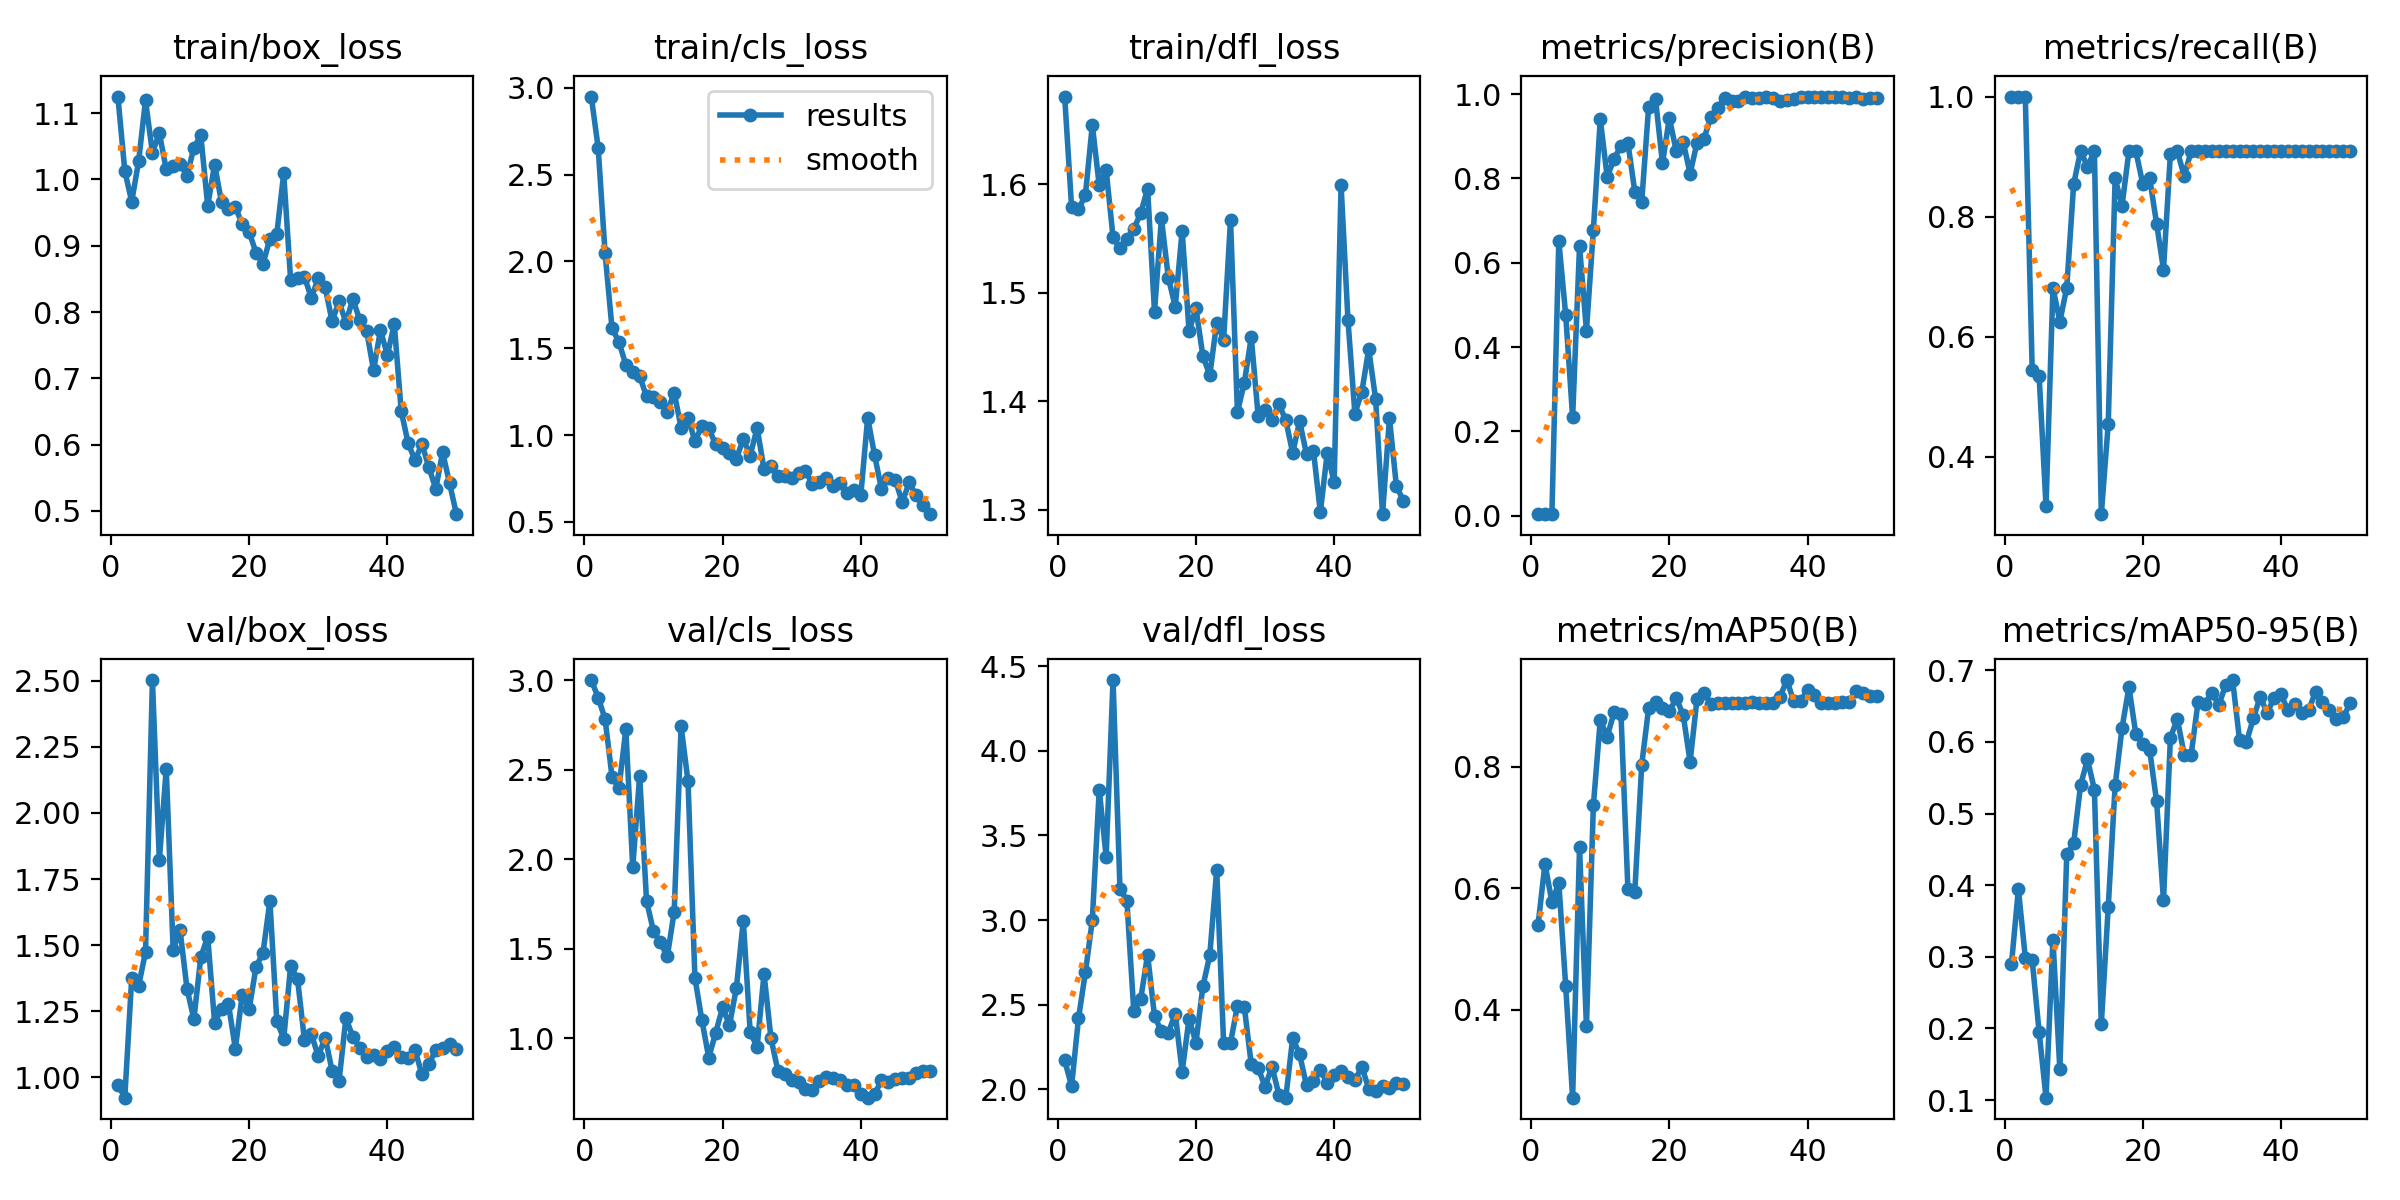

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename='./runs/detect/baseline_n/results.png', width=800)

## Matriz de confusión


Podemos apresiar que detecta bien los animales en validación además de que detecta una clase de background en cada uno de las clases.

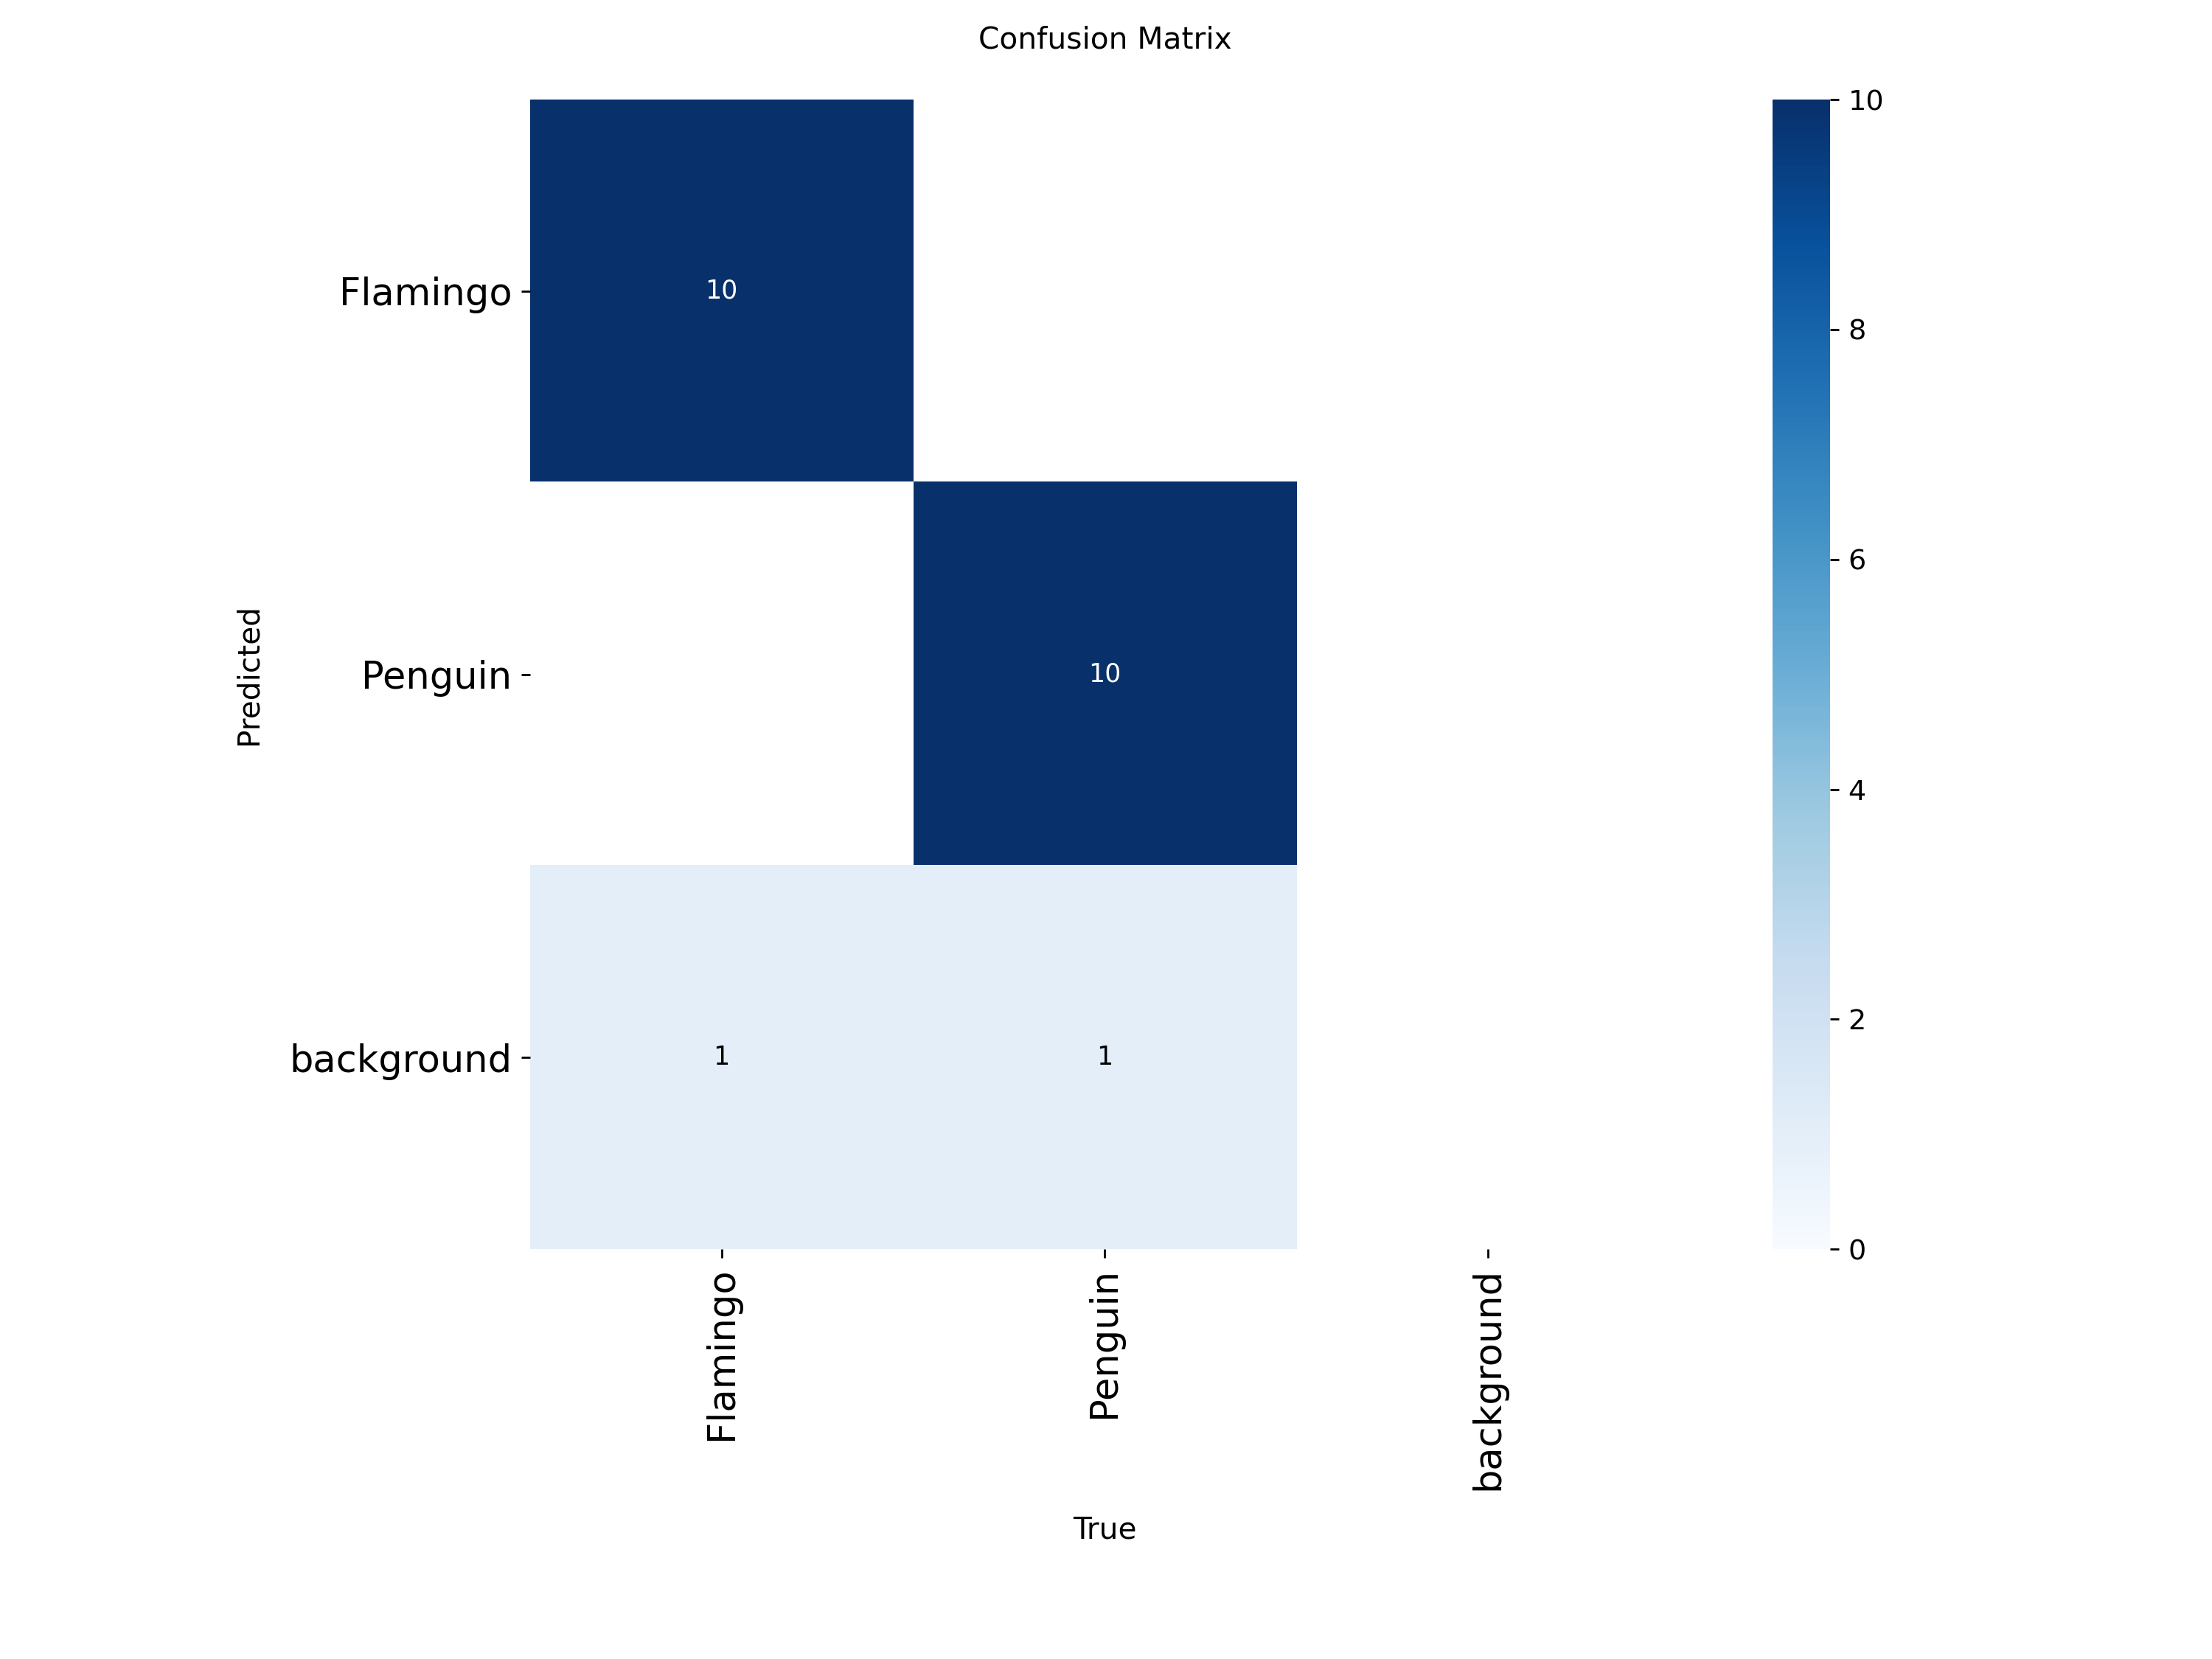

In [ ]:
IPyImage(filename='./runs/detect/baseline_n/confusion_matrix.png', width=600)

In [ ]:
#model = YOLO('./runs/detect/baseline_n/weights/best.pt')
model = YOLO('./runs/detect/baseline_n/weights/best.pt')
preds = model('./datasets/birds-penguins-and-flamingo/test/images')


image 1/10 /content/datasets/birds-penguins-and-flamingo/test/images/006_jpg.rf.b8ac5e1d3b6f751e043614f654681a18.jpg: 640x640 1 Flamingo, 18.5ms
image 2/10 /content/datasets/birds-penguins-and-flamingo/test/images/006_jpg.rf.da48b216a17c5299ddd5487e1a125fd8.jpg: 640x640 1 Penguin, 13.3ms
image 3/10 /content/datasets/birds-penguins-and-flamingo/test/images/014_jpg.rf.0a8bedf76aa9d3bdce579f868ac931b5.jpg: 640x640 1 Penguin, 10.5ms
image 4/10 /content/datasets/birds-penguins-and-flamingo/test/images/018_jpg.rf.35c95436f7a2c836aefd24f1157a7d7f.jpg: 640x640 1 Penguin, 9.8ms
image 5/10 /content/datasets/birds-penguins-and-flamingo/test/images/027_jpg.rf.abe289b6d8313ee28ba880f301019444.jpg: 640x640 1 Flamingo, 7.5ms
image 6/10 /content/datasets/birds-penguins-and-flamingo/test/images/029_jpg.rf.d0198ddff4f9b217429c52409d407f04.jpg: 640x640 1 Flamingo, 7.6ms
image 7/10 /content/datasets/birds-penguins-and-flamingo/test/images/034_jpg.rf.ce0579db7257276f6e23e6fcbea9a48f.jpg: 640x640 1 Flaming

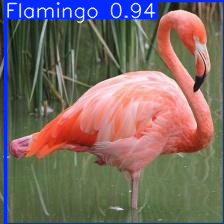

In [ ]:
import numpy as np
idx = np.random.randint(len(preds))
preds[idx].show()

In [ ]:
print(preds[2].boxes[0])

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.], device='cuda:0')
conf: tensor([0.9398], device='cuda:0')
data: tensor([[  4.8485,   0.0000, 223.3115, 222.9707,   0.9398,   1.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (224, 224)
shape: torch.Size([1, 6])
xywh: tensor([[114.0800, 111.4854, 218.4630, 222.9707]], device='cuda:0')
xywhn: tensor([[0.5093, 0.4977, 0.9753, 0.9954]], device='cuda:0')
xyxy: tensor([[  4.8485,   0.0000, 223.3115, 222.9707]], device='cuda:0')
xyxyn: tensor([[0.0216, 0.0000, 0.9969, 0.9954]], device='cuda:0')


In [ ]:
UMBRAL_CONF = 0.7
boxes = [box for box in preds[0].boxes if box.conf > UMBRAL_CONF]
print(len(boxes))

1


In [ ]:
conteos = Counter([int(box.cls) for box in boxes])
conteos

Counter({0: 1})


Conteos:
Flamingo: 1


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

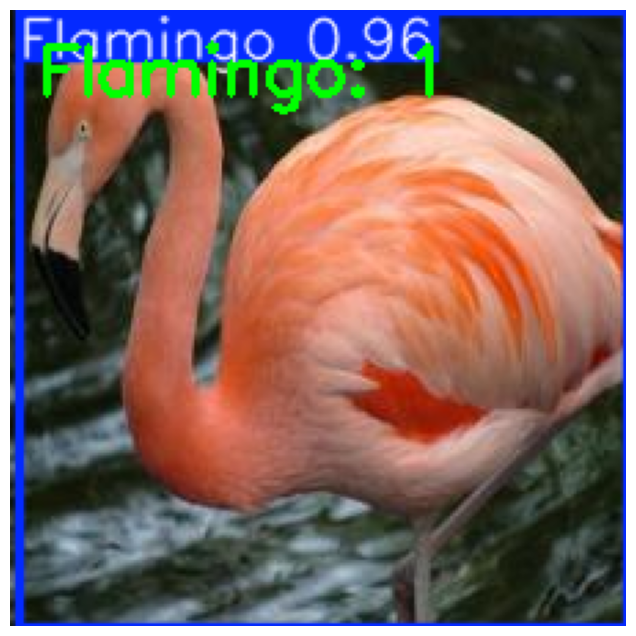

In [ ]:
import cv2 # OpenCV
import matplotlib.pyplot as plt

# Mapear categoría de objeto a nombres e imprimir conteos
nombres = model.names
print("\nConteos:")
for cls_id, num in conteos.items():
    print(f"{nombres[cls_id]}: {num}")


# Extraer imagen con los bounding boxes > UMBRAL_CONF
p = preds[6] # Predicción
mascara = p.boxes.conf > UMBRAL_CONF
p.boxes = p.boxes[mascara]
img_bboxes = p.plot() # Imagen con los bounding boxes filtrados

# Añadir anotación mostrando los conteos (esquina superior izquierda)
anotacion = ", ".join([f"{nombres[c]}: {n}" for c, n in conteos.items()])
cv2.putText(img_bboxes, anotacion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
            0.8, (0, 255, 0), 2)

# Convertir imagen de BGR a RGB
img_bboxes_rgb = cv2.cvtColor(img_bboxes, cv2.COLOR_BGR2RGB)

# Y mostrarla
plt.figure(figsize=(12, 8))
plt.imshow(img_bboxes_rgb)
plt.axis("off")

In [ ]:
from collections import Counter
import cv2
import matplotlib.pyplot as plt

def mostrar_conteos(modelo, ruta_img, umbral=0.5):
    """
    Función simplificada para contar objetos en una imagen.
    1. Detecta (filtrando por confianza).
    2. Cuenta.
    3. Muestra el resultado.
    """
    # 1. Predicción con filtro automático de confianza (conf=umbral)
    # Esto hace que el modelo ignore las cajas con baja probabilidad
    resultados = modelo(ruta_img, conf=umbral, verbose=False)
    pred = resultados[0]

    # 2. Realizar el conteo
    # pred.boxes.cls es una lista con los IDs de los objetos encontrados (ej: [0, 0, 0])
    clases_encontradas = [int(c) for c in pred.boxes.cls]
    conteos = Counter(clases_encontradas)

    # 3. Imprimir resultados (Texto)
    print(f"\n--- Conteo de objetos (Confianza > {umbral}) ---")
    if not conteos:
        print("No se detectaron objetos con suficiente confianza.")

    for id_clase, cantidad in conteos.items():
        nombre_objeto = modelo.names[id_clase]
        print(f" -> {nombre_objeto}: {cantidad}")

    # 4. Mostrar imagen (Gráfico)
    # plot() dibuja las cajas que pasaron el filtro
    img_con_cajas = pred.plot()

    # Convertir de BGR (OpenCV) a RGB (Matplotlib) para que los colores se vean bien
    img_rgb = cv2.cvtColor(img_con_cajas, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

    return conteos

In [ ]:
import os

RUTA_TST = './datasets/birds-penguins-and-flamingo/test/images/'
rutas_imgs = [f for f in os.listdir(RUTA_TST) if f.endswith('.jpg')]
rutas_imgs

['006_jpg.rf.da48b216a17c5299ddd5487e1a125fd8.jpg',
 '018_jpg.rf.35c95436f7a2c836aefd24f1157a7d7f.jpg',
 '034_jpg.rf.ce0579db7257276f6e23e6fcbea9a48f.jpg',
 '029_jpg.rf.d0198ddff4f9b217429c52409d407f04.jpg',
 '006_jpg.rf.b8ac5e1d3b6f751e043614f654681a18.jpg',
 '014_jpg.rf.0a8bedf76aa9d3bdce579f868ac931b5.jpg',
 '049_jpg.rf.d4697efb88c0755b230056285548aefa.jpg',
 '050_jpg.rf.699e5da78e15d5778695e2d64053e0d7.jpg',
 '044_jpg.rf.db2dd323441e654dce5019624fb5b75c.jpg',
 '027_jpg.rf.abe289b6d8313ee28ba880f301019444.jpg']


--- Conteo de objetos (Confianza > 0.5) ---
 -> Penguin: 1


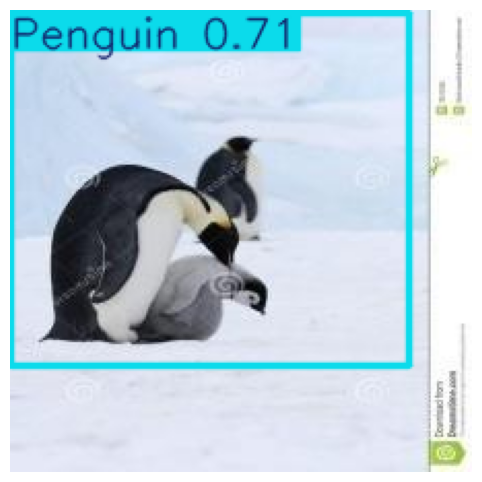

In [ ]:
conteo = mostrar_conteos(model, RUTA_TST + rutas_imgs[6])

## <span style="color: #7d5eeeb7;">MODELO BASE S</span>

In [ ]:


# 1. Cargar el modelo (nano, el más pequeño)
model = YOLO("yolo11s.pt")

# Afinar el modelo
baseline_s = model.train(data=yaml_path,
                      epochs=15 , # Número de iteraciones
                      imgsz=640, # Tamaño de las imágenes (máxima dimensión)
                      #batch = 32,
                      #patience = 10, Si en 5 épocas seguidas no mejora el mAP, para el entrenamiento
                      plots=True, # Guardar gráficos de entrenamiento
                      name = "baseline_s"
                      )


Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

# <span style="color: #2cdda8ff;">MODELO BASE L</span>

In [ ]:


# 1. Cargar el modelo (nano, el más pequeño)
inicio = time.time()
model = YOLO("yolo11l.pt")

# Afinar el modelo
baseline_l = model.train(data=yaml_path,
                      epochs=15, # Número de iteraciones
                      imgsz=640, # Tamaño de las imágenes (máxima dimensión)
                      #batch = 32,
                     # patience = 5, Si en 5 épocas seguidas no mejora el mAP, para el entrenamiento
                      plots=True, # Guardar gráficos de entrenamiento
                      name = "baseline_l"
                      )
final = time.time()
beaseline_l_time = final - inicio

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_l, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

<H1>  FINETUNING </H1>

Haremos un Finetuning de tanto del modelo S como el modelo L

In [ ]:
model_s = YOLO("yolo11s.pt")

In [ ]:
# Ver la estructura del modelo
print("Estructura del modelo YOLO11:")
print(model_s.model)

# Contar parámetros totales
total_params = sum(p.numel() for p in model_s.model.parameters())
print(f"\nTotal de parámetros: {total_params:,}")

Estructura del modelo YOLO11:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act)

In [ ]:
# Contar el número de capas/módulos
num_layers = len(list(model_s.model.modules()))
print(f" Total de módulos en el modelo: {num_layers}")

 Total de módulos en el modelo: 319


In [ ]:
for param in model_s.parameters():
    param.requires_grad = True

In [ ]:
# Método 1: Usar el parámetro 'freeze' durante el entrenamiento
# Congela las primeras N capas (por ejemplo, las primeras 10)

finetuning_s = model_s.train(
    data= yaml_path,
    epochs=50,    # Aumentamos un poco las épocas para afinar
    imgsz=640,
    freeze=10,         #  CLAVE: le estamos diciendo a Ultralytics que congele los primeros 10 bloques principales del modelo, que corresponden al backbone.
    lr0=0.005,           #  Learning rate reducido (mitad del estándar) para ser delicados
    plots=True,
    name='finetuning_s'
)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=finetuning_s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

<H1>FINETUNING MODLEO L </H1>

In [ ]:
model = YOLO("yolo11l.pt")

In [ ]:
# Ver la estructura del modelo
print("Estructura del modelo YOLO11:")
print(model.model)

# Contar parámetros totales
total_params = sum(p.numel() for p in model.model.parameters())
print(f"\nTotal de parámetros: {total_params:,}")

Estructura del modelo YOLO11:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       

In [ ]:
# Contar el número de capas/módulos
num_layers = len(list(model.model.modules()))
print(f" Total de módulos en el modelo: {num_layers}")

 Total de módulos en el modelo: 631


In [ ]:
 #Ver los primeros módulos (backbone)
print("\n Primeros 15 módulos (BACKBONE):")
for i, (name, module) in enumerate(list(model.model.named_modules())[:238]):
    print(f"  Capa {i}: {name} -> {type(module).__name__}")



 Primeros 15 módulos (BACKBONE):
  Capa 0:  -> DetectionModel
  Capa 1: model -> Sequential
  Capa 2: model.0 -> Conv
  Capa 3: model.0.conv -> Conv2d
  Capa 4: model.0.bn -> BatchNorm2d
  Capa 5: model.0.act -> SiLU
  Capa 6: model.1 -> Conv
  Capa 7: model.1.conv -> Conv2d
  Capa 8: model.1.bn -> BatchNorm2d
  Capa 9: model.2 -> C3k2
  Capa 10: model.2.cv1 -> Conv
  Capa 11: model.2.cv1.conv -> Conv2d
  Capa 12: model.2.cv1.bn -> BatchNorm2d
  Capa 13: model.2.cv2 -> Conv
  Capa 14: model.2.cv2.conv -> Conv2d
  Capa 15: model.2.cv2.bn -> BatchNorm2d
  Capa 16: model.2.m -> ModuleList
  Capa 17: model.2.m.0 -> C3k
  Capa 18: model.2.m.0.cv1 -> Conv
  Capa 19: model.2.m.0.cv1.conv -> Conv2d
  Capa 20: model.2.m.0.cv1.bn -> BatchNorm2d
  Capa 21: model.2.m.0.cv2 -> Conv
  Capa 22: model.2.m.0.cv2.conv -> Conv2d
  Capa 23: model.2.m.0.cv2.bn -> BatchNorm2d
  Capa 24: model.2.m.0.cv3 -> Conv
  Capa 25: model.2.m.0.cv3.conv -> Conv2d
  Capa 26: model.2.m.0.cv3.bn -> BatchNorm2d
  Capa 27:

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
# Método 1: Usar el parámetro 'freeze' durante el entrenamiento
# Congela las primeras N capas (por ejemplo, las primeras 10)

finetunning_l = model.train(
    data= yaml_path,
    epochs=50,    # Aumentamos un poco las épocas para afinar
    imgsz=640,
    freeze=10,         #  CLAVE: le estamos diciendo a Ultralytics que congele los primeros 10 bloques principales del modelo, que corresponden al backbone.
    lr0=0.005,           #  Learning rate reducido (mitad del estándar) para ser delicados
    plots=True,
    batch= 8,
    name='finetuning_l'
)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=finetuning_l, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

In [ ]:
model_tl = YOLO('./runs/detect/finetuning_l/weights/best.pt')
preds_tl = model_tl('./datasets/birds-penguins-and-flamingo/test/images')

## COMPARATIVA DE LOS MODELOS

In [ ]:

model_list = model_check()
for mdl in model_list
    save_model_comparison(mid)